In [1]:
#install.packages("cluster")
#install.packages("flexclust")
#install.packages("e1071")
#install.packages("NLP")
library(ggplot2)
library(cluster)
library(flexclust)
library(e1071)
library(IRdisplay)
library(NLP)

Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



In [34]:
# These things take a while to complete, let's keep them cached!
cached.computation <- function(file, func = NULL, ...) {
    actual_file <- sprintf("cached.computation/%s.rds", file)
    tryCatch({
        ret <- readRDS(file = actual_file)
        #print(sprintf("[cached.computation] Fetched from %s", actual_file))
        ret
    }, error = function(e) {
        print(e)
        print(sprintf("[cached.computation] Recomputing %s", actual_file))
        start.time <- Sys.time()
        ret <- func(...)
        end.time <- Sys.time()
        print(end.time - start.time)
        saveRDS(ret, file = actual_file)
        ret
    })
}

In [3]:
# Number of principal components necessary to explain a given amount of variance
num.pca.features <- Vectorize(
    vectorize.args = "cumulative_variance", 
    FUN = function(pca, cumulative_variance = 0.9) {
        importance <- summary(pca)$importance[3,]
        min(which(importance >= cumulative_variance))
    }
)

In [4]:
# Create a table with "Number of Features ⨯ Explained Variance"
pca.cumulative.variance.table <- function(pca, pca.scaled, values) {
    data.frame(
        acum.variance = values,
        num.features = num.pca.features(pca, values),
        num.features.scaled = num.pca.features(pca.scaled, values)
    )
}

In [5]:
# Plots the chart "Number of Features ⨯ Explained Variance"
plot.pca.cumulative.variance <- function(pca, pca.scaled) {
    cumulative.variance.df <- data.frame(
        num.components = 0:ncol(pca$rotation), 
        cumulative.variance = c(0, summary(pca)$importance[3,]),
        cumulative.variance.scaled = c(0, summary(pca.scaled)$importance[3,])
    )

    p <- ggplot(data=cumulative.variance.df, aes(x=num.components))
    p <- p + geom_line(aes(y=cumulative.variance, color="Without Scaling"))
    p <- p + geom_line(aes(y=cumulative.variance.scaled, color="With Scaling"))
    p <- p + scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.1), name = "Cumulative Variance")
    p <- p + scale_x_continuous(limits = c(0, ncol(pca$rotation)), name = "Number of Principal Components")
    p <- p + ggtitle("PCA Cumulative Variance")
    p
}

In [1]:
# Read the dataset from CSV files
read.dataset <- function() {
    dataset <- read.csv(gzfile("dataset/headlines.csv.gz"))
    dataset$publish_date <- strptime(dataset$publish_date, format = "%Y%m%d")
    dataset$features <- read.csv(gzfile("dataset/features.csv.gz"))
    dataset
}
dataset <- read.dataset()
sprintf("Dataset has %d records with %d features", nrow(dataset), ncol(dataset$features))

[1] "Dataset has 25000 records with 2181 features"

acum.variance,num.features,num.features.scaled
0.80,1210,1515
0.85,1390,1654
0.90,1598,1804
0.95,1845,1971


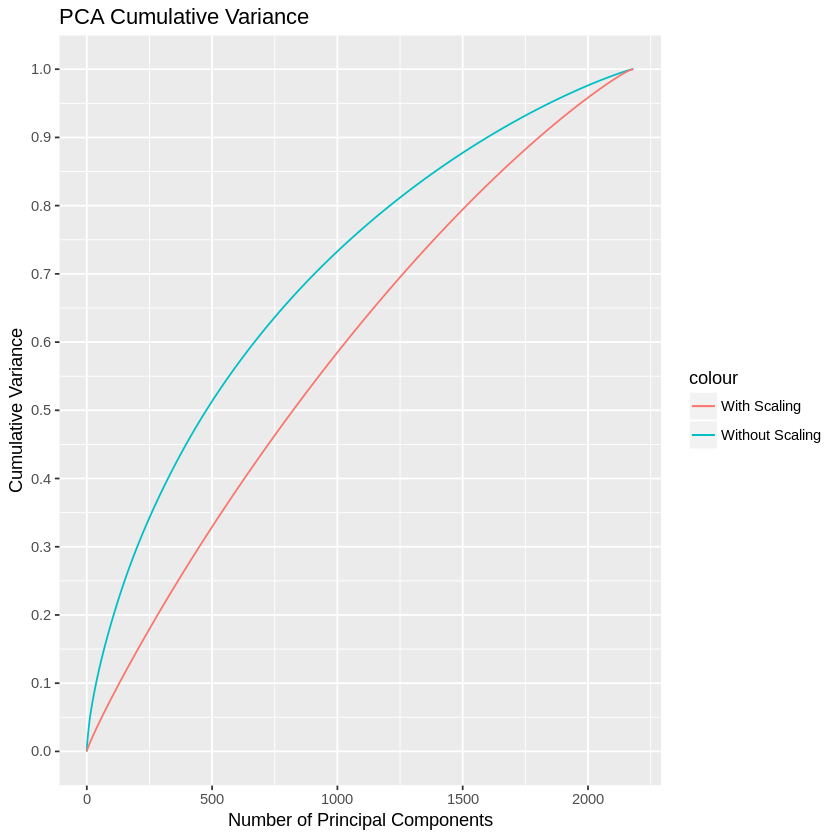

In [7]:
# Extract the PCA from the dataset (With and without scaling)
dataset.pca        <- cached.computation("pca", prcomp, dataset$features)
dataset.pca.scaled <- cached.computation("pca-scaled", prcomp, dataset$features, scale = T)

pca.cumulative.variance.table(dataset.pca, dataset.pca.scaled, c(0.80, 0.85, 0.90, 0.95))
plot.pca.cumulative.variance(dataset.pca, dataset.pca.scaled)

In [8]:
cluster.algorithms <- list(
    kmeans = function(features, k, distances) {
        kcluster <- kmeans(features, k, nstart = 10)
        kcluster.centers <- kcluster$centers
        kcluster.preds <- kcluster$cluster
        tot.withinss <- kcluster$tot.withinss
        sil <- silhouette(kcluster.preds, distances)
        
        list(
            kmeans = kcluster,
            centers = kcluster.centers,
            preds = kcluster.preds,
            tot.withinss = tot.withinss,
            silhouette = sil,
            silhouette.avg.width = summary(sil)$avg.width
        )
    },
    kmedians = function(features, k, distances) {
        kcluster <- kcca(features, k=k, family=kccaFamily("kmedians"))
        kcluster.centers <- kcluster@centers
        kcluster.preds <- kcluster@cluster
        tot.withinss <- sum(rowSums((features - kcluster.centers[kcluster.preds, ])^2))
        sil <- silhouette(kcluster.preds, distances)
        
        list(
            kcca = kcluster,
            centers = kcluster.centers,
            preds = kcluster.preds,
            tot.withinss = tot.withinss,
            silhouette = sil,
            silhouette.avg.width = summary(sil)$avg.width
        )
    },
    fuzzy = function(features, k, distances) {
        kcluster <- cmeans(features, k)
        kcluster.centers <- kcluster$centers
        kcluster.preds <- kcluster$cluster
        tot.withinss <- sum(rowSums((features - kcluster.centers[kcluster.preds, ])^2))
        sil <- silhouette(kcluster.preds, distances)

        list(
            cmeans = kcluster,
            centers = kcluster.centers,
            preds = kcluster.preds,
            tot.withinss = tot.withinss,
            silhouette = sil,
            silhouette.avg.width = summary(sil)$avg.width
        )
    }
)

In [9]:
for (cum.variance in c(0.80, 0.85, 0.90)) {
    for (scaled in c(F, T)) {
        if (!scaled) {
            pca <- dataset.pca
        } else {
            pca <- dataset.pca.scaled
        }
    
        num.features <- num.pca.features(pca, cum.variance)
        features <- pca$x[, 1:num.features]
        dist.filename <- sprintf("dist-%d%%%s", 100*cum.variance, ifelse(scaled, "-scaled", ""))
        d <- cached.computation(dist.filename, dist, features)
        
        for (k in 2:20) {
            for (algorithm.name in names(cluster.algorithms)) {
                f <- cluster.algorithms[[algorithm.name]]
                cluster.filename <- sprintf("%s-%d-%d%%%s", algorithm.name, k, 100*cum.variance, ifelse(scaled, "-scaled", ""))
                kluster <- cached.computation(cluster.filename, f, features, k, d)
                print(sprintf("%s: Silhouette = %.3f, tot.withinss=%.0f", cluster.filename, kluster$silhouette.avg.width, kluster$tot.withinss))
            }
        }
    }
}

In [11]:
get.cluster.metrics <- function() {
    data <- data.frame(
        filename = character(0),
        algorithm.name = character(0),
        k = numeric(0),
        pca.scaled = logical(0),
        pca.scaled.name = character(0),
        pca.variance = numeric(0),
        pca.variance.name = character(0),
        silhouette = numeric(0),
        err.sqr = numeric(0),
        stringsAsFactors = FALSE
    )

    for (cum.variance in c(0.80, 0.85, 0.90)) {
        for (scaled in c(F, T)) {
            for (k in 2:20) {
                for (algorithm.name in names(cluster.algorithms)) {
                    cluster.filename <- sprintf("%s-%d-%d%%%s", algorithm.name, k, 100*cum.variance, ifelse(scaled, "-scaled", ""))
                    tryCatch({
                        kluster <- cached.computation(cluster.filename)

                        data[nrow(data) + 1,] <- list(
                            filename = cluster.filename,
                            algorithm.name = algorithm.name,
                            k = k,
                            pca.scaled = scaled,
                            pca.scaled.name = ifelse(scaled, "Scaled PCA", "Non-Scaled PCA"),
                            pca.variance = cum.variance,
                            pca.variance.name = sprintf("%d%% Variance", 100*cum.variance),
                            silhouette = kluster$silhouette.avg.width,
                            err.sqr = kluster$tot.withinss
                        )      

                    }, error = function(e) {
                    })
                }
            }
        }
    }
    
    data
}
all.cluster.metrics <- get.cluster.metrics()

`geom_smooth()` using method = 'loess'


`geom_smooth()` using method = 'loess'


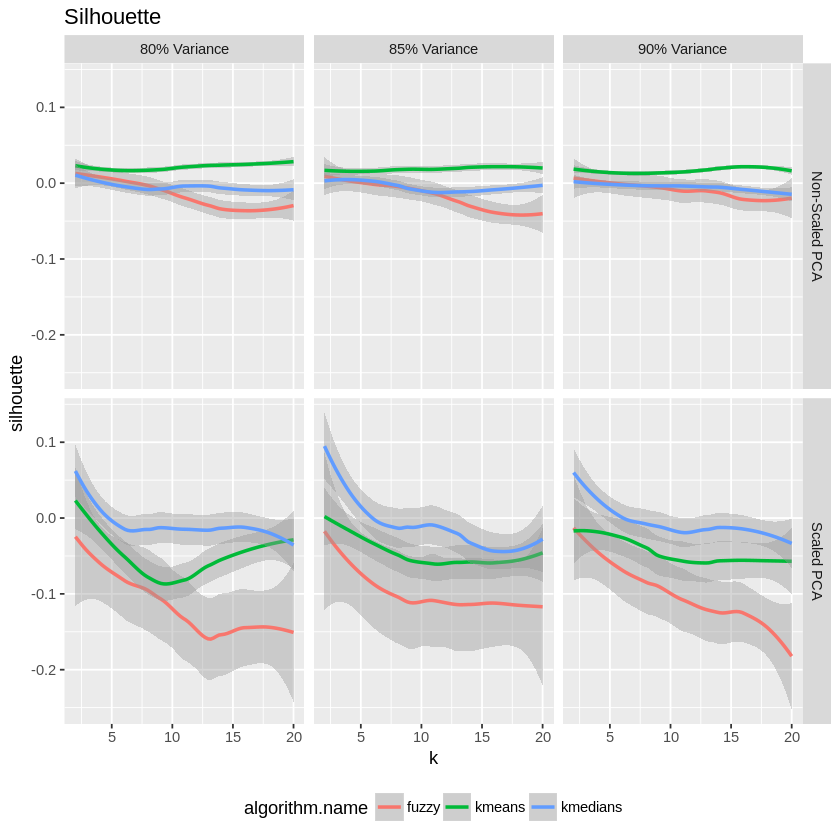

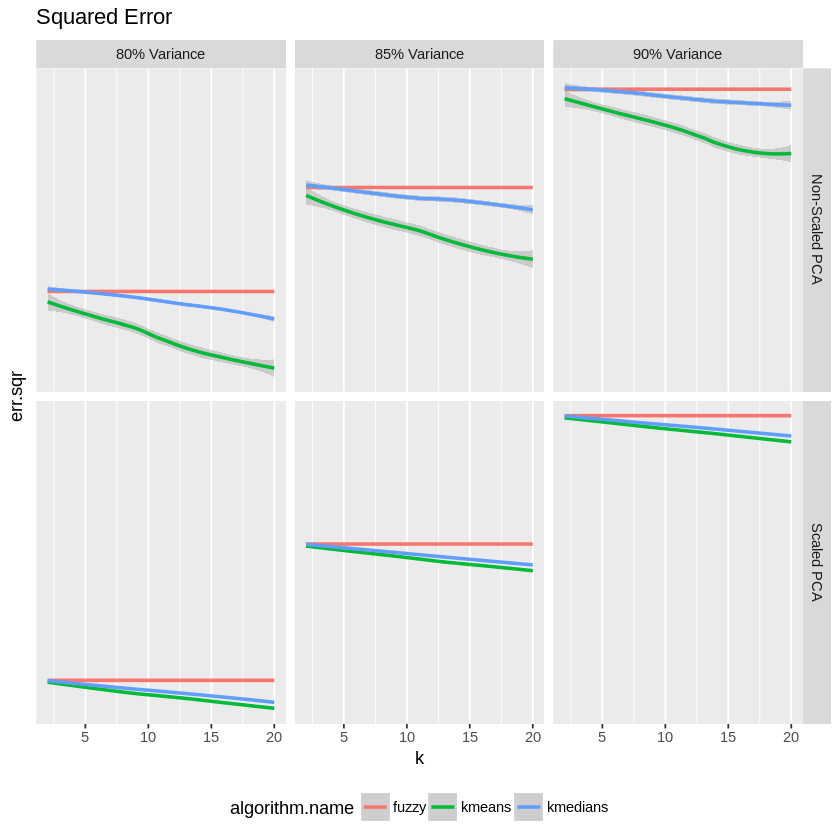

In [12]:
plot.cluster.metrics <- function(cluster.metrics) {
    p1 <- ggplot(data=cluster.metrics, aes(x=k, y=silhouette, color=algorithm.name))
    p1 <- p1 + geom_smooth(aes())
    p1 <- p1 + ggtitle("Silhouette")
    p1 <- p1 + facet_grid(pca.scaled.name ~ pca.variance.name)
    p1 <- p1 + theme(legend.position="bottom")
    display(p1)
    
    p2 <- ggplot(data=cluster.metrics, aes(x=k, y=err.sqr, color=algorithm.name))
    p2 <- p2 + geom_smooth(aes())
    p2 <- p2 + ggtitle("Squared Error")
    p2 <- p2 + facet_grid(pca.scaled.name ~ pca.variance.name, scale = "free_y")
    p2 <- p2 + theme(legend.position="bottom")
    p2 <- p2 + scale_y_log10()
    display(p2)
}
plot.cluster.metrics(all.cluster.metrics)

In [13]:
get.analysis.clusters <- function(cluster.metrics) {
    c1 <- cluster.metrics[
        (cluster.metrics$k >= 5) &
        #(cluster.metrics$algorithm.name=='kmeans') &
        (cluster.metrics$pca.scaled == F) &
        (cluster.metrics$pca.variance >= 0.85 & all.cluster.metrics$pca.variance <= 0.90)
        ,]
    c1 <- c1[order(c1$silhouette, decreasing = T)  ,]
    c1[1,]

    c2 <- cluster.metrics[
        (cluster.metrics$k == 5) &
        #(cluster.metrics$algorithm.name=='kmedians') &
        (cluster.metrics$pca.scaled == T) &
        (cluster.metrics$pca.variance >= 0.85 & all.cluster.metrics$pca.variance <= 0.90)
        ,]
    c2 <- c2[order(c2$silhouette, decreasing = T)  ,]
    c2[1,]
    
    rbind(c1[1,], c2[1,])
}
analysis.clusters <- get.analysis.clusters(all.cluster.metrics)
analysis.clusters

,filename,algorithm.name,k,pca.scaled,pca.scaled.name,pca.variance,pca.variance.name,silhouette,err.sqr
274,kmeans-17-90%,kmeans,17,FALSE,Non-Scaled PCA,0.90,90% Variance,0.02652060,21038.3
182,kmedians-5-85%-scaled,kmedians,5,TRUE,Scaled PCA,0.85,85% Variance,0.05100759,46268333.1


## Escolha de clusters

Ao analizar a curva _Número de Componentes Principais ⨯ Variância acumulada_, era evidente que a versão não-normalizada do seria melhor.

E isso realmente ocorreu de _modo geral_. Para nossa surpresa, o PCA normalizado deu _excelentes_ resultados com k-medians e valores pequenos de `K`.

Apesar deste excelente resultado, temos uma certa desconfiança neste cluster devido à falta de consistência nos resultados, tanto devido ao uso da normalização quanto aos demais resultados do algoritmo k-medians.

Desta forma, analisaremos também um segundo cluster obtido com PCA não-normalizado. Neste cenário, o algoritmo K-means obteve performance consistentemente melhor que os demais em ambas as métricas, para diversos valores de `K`, obtendo a melhor silhueta por volta de `K=17`.

Vale lembrar que o algoritmo k-means foi executado com `nstart = 10`, ou seja, foi escolhido o melhor resultado de 10 execuções para cada combinação de parâmetros analizada. Infelizmente não pudemos fazer o mesmo com os demais algoritmos devido ao elevado tempo CPU necessário.

Desta forma, analizaremos 2 clusters:

- __kmedians__, k=5, PCA normalizado, 85% da variância (1654 features), silhueta 0.051
- __kmeans__, k=17, PCA não-normalizado, 90% da variância (1598 features), silhueta 0.026

In [14]:
word.filter <- function(x) {
  return (!(x %in% c("in", "at", "on","with", "of","a", "an", "for", "to", "too", "she", "it",
                     "which", "whom", "be", "the", "where", "who", "and", "by", "or","he")))
}

bigrams <- function(s){
  w <- strsplit(s, " ", fixed = TRUE)[[1L]];
  w <- Filter(word.filter, w);
  return(vapply(ngrams(w, 2L), paste, "", collapse = " "));
}

bigram.stats <- function(headlines, clusters){
  res <- list();
  
  for (i in 1:max(clusters)){
    x <- lapply(headlines[clusters == i], as.character);
    res[[i]] <- table(unlist(lapply(x, bigrams)));
  }
  return(res);
}

bigram.analysis <- function(kluster) {
    headlines <- dataset$headline_text
    clusters <- kluster$preds
    count <- bigram.stats(headlines, clusters)
    display(count)
}

for (cluster.filename in analysis.clusters$filename) {
    bigram.analysis(cached.computation(cluster.filename))
    break
}

In [37]:
for (i in 1:nrow(analysis.clusters)) {
    cum.variance <- analysis.clusters$pca.variance[i]
    scaled <- analysis.clusters$pca.scaled[i]
    algorithm.name <- analysis.clusters$algorithm.name[i]
    k <- analysis.clusters$k[i]
    
    if (!scaled) {
        pca <- dataset.pca
    } else {
        pca <- dataset.pca.scaled
    }
    num.features <- num.pca.features(pca, cum.variance)
    features <- pca$x[dataset$publish_date$year == 116 , 1:num.features]

    dist.filename <- sprintf("2016-dist-%d%%%s", 100*cum.variance, ifelse(scaled, "-scaled", ""))
    d <- cached.computation(dist.filename, dist, features)
    
    for (k in 2:20) {
        f <- cluster.algorithms[[algorithm.name]]

        cluster.filename <- sprintf("2016-%s-%d-%d%%%s", algorithm.name, k, 100*cum.variance, ifelse(scaled, "-scaled", ""))

        print(sprintf("Starting processing of %s", cluster.filename))
        kluster <- cached.computation(cluster.filename, f, features, k, d)
        print(sprintf("%s: Silhouette = %.3f, tot.withinss=%.0f", cluster.filename, kluster$silhouette.avg.width, kluster$tot.withinss))
    }
}


[1] "Starting processing of 2016-kmeans-2-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-2-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-2-90%.rds"
Time difference of 18.94248 secs
[1] "2016-kmeans-2-90%: Silhouette = 0.013, tot.withinss=2827"
[1] "Starting processing of 2016-kmeans-3-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-3-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-3-90%.rds"
Time difference of 22.43285 secs
[1] "2016-kmeans-3-90%: Silhouette = 0.004, tot.withinss=2821"
[1] "Starting processing of 2016-kmeans-4-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-4-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-4-90%.rds"
Time difference of 27.35287 secs
[1] "2016-kmeans-4-90%: Silhouette = 0.013, tot.withinss=2806"
[1] "Starting processing of 2016-kmeans-5-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-5-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-5-90%.rds"
Time difference of 28.85864 secs
[1] "2016-kmeans-5-90%: Silhouette = 0.008, tot.withinss=2805"
[1] "Starting processing of 2016-kmeans-6-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-6-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-6-90%.rds"
Time difference of 24.30927 secs
[1] "2016-kmeans-6-90%: Silhouette = 0.009, tot.withinss=2799"
[1] "Starting processing of 2016-kmeans-7-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-7-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-7-90%.rds"
Time difference of 25.6683 secs
[1] "2016-kmeans-7-90%: Silhouette = 0.012, tot.withinss=2781"
[1] "Starting processing of 2016-kmeans-8-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-8-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-8-90%.rds"
Time difference of 27.31843 secs
[1] "2016-kmeans-8-90%: Silhouette = 0.000, tot.withinss=2781"
[1] "Starting processing of 2016-kmeans-9-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-9-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-9-90%.rds"
Time difference of 26.94979 secs
[1] "2016-kmeans-9-90%: Silhouette = 0.012, tot.withinss=2766"
[1] "Starting processing of 2016-kmeans-10-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-10-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-10-90%.rds"
Time difference of 33.52071 secs
[1] "2016-kmeans-10-90%: Silhouette = 0.013, tot.withinss=2763"
[1] "Starting processing of 2016-kmeans-11-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-11-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-11-90%.rds"
Time difference of 31.29144 secs
[1] "2016-kmeans-11-90%: Silhouette = 0.015, tot.withinss=2756"
[1] "Starting processing of 2016-kmeans-12-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-12-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-12-90%.rds"
Time difference of 27.75389 secs
[1] "2016-kmeans-12-90%: Silhouette = 0.016, tot.withinss=2749"
[1] "Starting processing of 2016-kmeans-13-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-13-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-13-90%.rds"
Time difference of 30.60468 secs
[1] "2016-kmeans-13-90%: Silhouette = 0.011, tot.withinss=2739"
[1] "Starting processing of 2016-kmeans-14-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-14-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-14-90%.rds"
Time difference of 32.82914 secs
[1] "2016-kmeans-14-90%: Silhouette = 0.017, tot.withinss=2729"
[1] "Starting processing of 2016-kmeans-15-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-15-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-15-90%.rds"
Time difference of 30.9131 secs
[1] "2016-kmeans-15-90%: Silhouette = 0.017, tot.withinss=2732"
[1] "Starting processing of 2016-kmeans-16-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-16-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-16-90%.rds"
Time difference of 34.43885 secs
[1] "2016-kmeans-16-90%: Silhouette = 0.017, tot.withinss=2726"
[1] "Starting processing of 2016-kmeans-17-90%"
[1] "2016-kmeans-17-90%: Silhouette = 0.015, tot.withinss=2714"
[1] "Starting processing of 2016-kmeans-18-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-18-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-18-90%.rds"
Time difference of 35.95431 secs
[1] "2016-kmeans-18-90%: Silhouette = 0.019, tot.withinss=2706"
[1] "Starting processing of 2016-kmeans-19-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-19-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-19-90%.rds"
Time difference of 36.05544 secs
[1] "2016-kmeans-19-90%: Silhouette = 0.020, tot.withinss=2705"
[1] "Starting processing of 2016-kmeans-20-90%"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmeans-20-90%.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmeans-20-90%.rds"
Time difference of 39.7444 secs
[1] "2016-kmeans-20-90%: Silhouette = 0.019, tot.withinss=2698"
[1] "Starting processing of 2016-kmedians-2-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-2-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-2-85%-scaled.rds"
Time difference of 29.12832 secs
[1] "2016-kmedians-2-85%-scaled: Silhouette = 0.045, tot.withinss=6393916"
[1] "Starting processing of 2016-kmedians-3-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-3-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-3-85%-scaled.rds"
Time difference of 20.25461 secs
[1] "2016-kmedians-3-85%-scaled: Silhouette = 0.021, tot.withinss=6386962"
[1] "Starting processing of 2016-kmedians-4-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-4-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-4-85%-scaled.rds"
Time difference of 17.57008 secs
[1] "2016-kmedians-4-85%-scaled: Silhouette = 0.025, tot.withinss=6369037"
[1] "Starting processing of 2016-kmedians-5-85%-scaled"
[1] "2016-kmedians-5-85%-scaled: Silhouette = 0.035, tot.withinss=6374640"
[1] "Starting processing of 2016-kmedians-6-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-6-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-6-85%-scaled.rds"
Time difference of 22.0875 secs
[1] "2016-kmedians-6-85%-scaled: Silhouette = -0.024, tot.withinss=6350291"
[1] "Starting processing of 2016-kmedians-7-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-7-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-7-85%-scaled.rds"
Time difference of 19.64172 secs
[1] "2016-kmedians-7-85%-scaled: Silhouette = -0.032, tot.withinss=6369634"
[1] "Starting processing of 2016-kmedians-8-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-8-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-8-85%-scaled.rds"
Time difference of 20.23801 secs
[1] "2016-kmedians-8-85%-scaled: Silhouette = -0.026, tot.withinss=6356092"
[1] "Starting processing of 2016-kmedians-9-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-9-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-9-85%-scaled.rds"
Time difference of 27.95638 secs
[1] "2016-kmedians-9-85%-scaled: Silhouette = -0.068, tot.withinss=6362247"
[1] "Starting processing of 2016-kmedians-10-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-10-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-10-85%-scaled.rds"
Time difference of 47.80927 secs
[1] "2016-kmedians-10-85%-scaled: Silhouette = -0.041, tot.withinss=6337337"
[1] "Starting processing of 2016-kmedians-11-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-11-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-11-85%-scaled.rds"
Time difference of 30.53832 secs
[1] "2016-kmedians-11-85%-scaled: Silhouette = -0.048, tot.withinss=6336587"
[1] "Starting processing of 2016-kmedians-12-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-12-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-12-85%-scaled.rds"
Time difference of 36.91745 secs
[1] "2016-kmedians-12-85%-scaled: Silhouette = -0.028, tot.withinss=6318524"
[1] "Starting processing of 2016-kmedians-13-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-13-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-13-85%-scaled.rds"
Time difference of 29.73971 secs
[1] "2016-kmedians-13-85%-scaled: Silhouette = -0.014, tot.withinss=6324001"
[1] "Starting processing of 2016-kmedians-14-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-14-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-14-85%-scaled.rds"
Time difference of 31.2949 secs
[1] "2016-kmedians-14-85%-scaled: Silhouette = -0.035, tot.withinss=6330829"
[1] "Starting processing of 2016-kmedians-15-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-15-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-15-85%-scaled.rds"
Time difference of 1.1396 mins
[1] "2016-kmedians-15-85%-scaled: Silhouette = -0.013, tot.withinss=6317216"
[1] "Starting processing of 2016-kmedians-16-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-16-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-16-85%-scaled.rds"
Time difference of 36.16227 secs
[1] "2016-kmedians-16-85%-scaled: Silhouette = -0.058, tot.withinss=6310894"
[1] "Starting processing of 2016-kmedians-17-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-17-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-17-85%-scaled.rds"
Time difference of 1.853373 mins
[1] "2016-kmedians-17-85%-scaled: Silhouette = 0.001, tot.withinss=6280252"
[1] "Starting processing of 2016-kmedians-18-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-18-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-18-85%-scaled.rds"
Time difference of 43.28563 secs
[1] "2016-kmedians-18-85%-scaled: Silhouette = 0.007, tot.withinss=6291254"
[1] "Starting processing of 2016-kmedians-19-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-19-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-19-85%-scaled.rds"
Time difference of 32.06112 secs
[1] "2016-kmedians-19-85%-scaled: Silhouette = -0.040, tot.withinss=6272319"
[1] "Starting processing of 2016-kmedians-20-85%-scaled"


Warning message in gzfile(file, "rb"):
“cannot open compressed file 'cached.computation/2016-kmedians-20-85%-scaled.rds', probable reason 'No such file or directory'”

<simpleError in gzfile(file, "rb"): cannot open the connection>
[1] "[cached.computation] Recomputing cached.computation/2016-kmedians-20-85%-scaled.rds"
Time difference of 33.03834 secs
[1] "2016-kmedians-20-85%-scaled: Silhouette = -0.060, tot.withinss=6295579"
